In [1]:
import pinecone
import os
from deepface import DeepFace
from deepface.commons import functions, distance as dst
import tqdm
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
pinecone.init(api_key = "YOUR_API_KEY")

# Create an index

In [3]:
pinecone.delete_index("deepface")

100%|██████████| 1/1 [00:14<00:00, 14.18s/it]


{'success': True}

In [4]:
existig_indexes = pinecone.list_indexes() 

In [5]:
engine = 'approximated' #approximated, exact

if "deepface" not in existig_indexes:
    pinecone.create_index(name = "deepface", metric = "euclidean", engine_type = engine)

100%|██████████| 3/3 [00:16<00:00,  5.66s/it]


# Connect to index

In [6]:
index = pinecone.Index("deepface")

# Find embeddings

In [7]:
model = DeepFace.build_model("Facenet")

In [8]:
img_paths = []
for root, dirs, files in os.walk("deepface/tests/dataset"):
    for file in files:
        if '.jpg' in file:
            img_paths.append(root+"/"+file)

In [9]:
embeddings = []
for i in tqdm.tqdm(range(0, len(img_paths))):
    img_path = img_paths[i]
    embedding = DeepFace.represent(img_path = img_path, model_name = 'Facenet', model = model)
    embeddings.append(embedding)

100%|██████████| 60/60 [01:32<00:00,  1.54s/it]


# Synthetic data

In [10]:
for i in tqdm.tqdm(range(60, 100000)):
    embedding = []
    for j in range(0, 128):
        embedding.append(random.uniform(-2, 2))
    
    embeddings.append(embedding)
    img_paths.append('dummy_%d.jpg' % (i))

100%|██████████| 99940/99940 [00:04<00:00, 20779.00it/s]


# Master data

In [11]:
df = pd.DataFrame(img_paths, columns = ["img_path"])
df["embedding"] = embeddings

In [12]:
df.head()

,img_path,embedding
0,deepface/tests/dataset/img36.jpg,"[0.7592520713806152, -0.5279755592346191, -0.8..."
1,deepface/tests/dataset/img37.jpg,"[1.479617714881897, 0.6147245168685913, -0.930..."
2,deepface/tests/dataset/img23.jpg,"[2.197262763977051, 1.78609299659729, -1.00542..."
3,deepface/tests/dataset/img35.jpg,"[0.6650556325912476, 0.7296856641769409, -0.48..."
4,deepface/tests/dataset/img21.jpg,"[0.12738361954689026, 0.7459821701049805, -1.5..."


In [13]:
df.shape

(100000, 2)

# Inserting data

In [14]:
chunk_size = 1000
cycles = int(df.shape[0] / chunk_size) + 1

In [15]:
retry_count = 3

missings = []

for i in tqdm.tqdm(range(0, cycles)):
    if i >= 0:
        valid_from = i * chunk_size
        valid_until = min(i * chunk_size + chunk_size, df.shape[0])

        if valid_from >= df.shape[0]:
            break

        valid_frame = df.iloc[valid_from:valid_until]

        is_successful = False

        for j in range(0, retry_count):
            try:
                index.upsert(items=zip(valid_frame.img_path, valid_frame.embedding), disable_progress_bar = True)
                is_successful = True
                break
            except:
                time.sleep(1)

        if is_successful != True:
            missings.append(i)

 99%|█████████▉| 100/101 [13:56<00:08,  8.37s/it]  


In [17]:
missings

[]

In [18]:
index.info()

InfoResult(index_size=100000)

# Target

In [19]:
img_path = "hello-world/source.jpg"

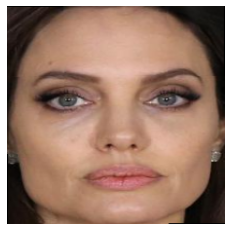

In [20]:
target_img = functions.preprocess_face(img_path, detector_backend = 'mtcnn')[0]
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(target_img)

In [21]:
target_embedding = DeepFace.represent(img_path = img_path, model_name = 'Facenet', model = model)

# Query on vector db

In [22]:
tic = time.time()
results = index.query(queries=[target_embedding], top_k = 5)
toc = time.time()

1it [00:00,  3.23it/s]


In [23]:
print(toc-tic," seconds")

0.31178808212280273  seconds


deepface/tests/dataset/img2.jpg  with score  -36.68727493286133


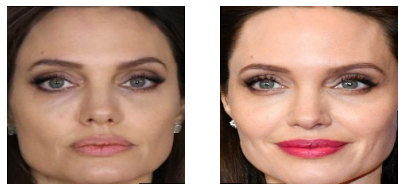

-------------
deepface/tests/dataset/img4.jpg  with score  -42.800018310546875


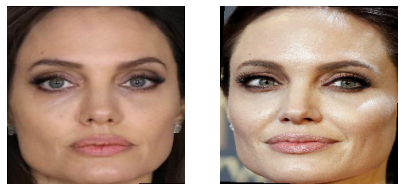

-------------
deepface/tests/dataset/img7.jpg  with score  -56.982872009277344


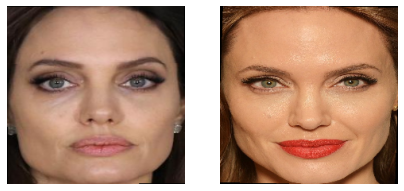

-------------
deepface/tests/dataset/img5.jpg  with score  -58.87826919555664


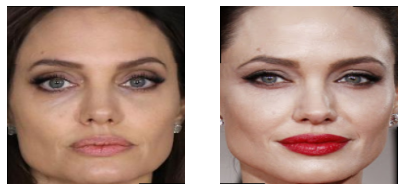

-------------
deepface/tests/dataset/img10.jpg  with score  -60.713897705078125


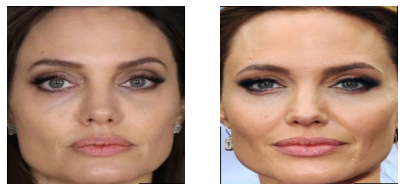

-------------


In [24]:
for result in results:
    keys = result.ids
    scores = result.scores
    
    for i in range(0, len(keys)):
        key = keys[i]
        score = scores[i]
        
        print(key, " with score ", score)
        
        img = functions.preprocess_face(key, detector_backend = 'mtcnn')[0]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig = plt.figure(figsize=(7, 7))
        
        ax1 = fig.add_subplot(1,2,1)
        plt.imshow(target_img)
        plt.axis('off')
        
        ax2 = fig.add_subplot(1,2,2)
        plt.imshow(img)
        plt.axis('off')
        
        plt.show()
        
        print("-------------")
    

# Key-Value Store

In [25]:
tic = time.time()
resp = index.unary_fetch(id = "deepface/tests/dataset/img2.jpg")
toc = time.time()
print(toc-tic," seconds")

142.01367688179016  seconds


In [26]:
threshold = 10 #Fine Tuned Threshold for Facenet and Euclidean Distance pair

In [27]:
distance = dst.findEuclideanDistance(target_embedding, resp.vector.tolist())

In [28]:
distance

6.057002019425613

In [29]:
distance < threshold

True